In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, Conv2DTranspose, concatenate

In [ ]:
# Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

# Change to the directory containing your images
os.chdir('/content/drive/MyDrive/FinalProject_QBIO499')

Mounted at /content/drive


In [ ]:
! ls

 filenames.txt	      images	  'QBIO 499 Final Project Paper.gdoc'   unet_weights.h5
 finalproject.ipynb   labels.csv   qbio499_final_proposal.gdoc


In [ ]:
data = pd.read_csv('labels.csv')
filenames = pd.read_csv('filenames.txt', names=['Image Index'])
image1_data = pd.merge(data, filenames, on='Image Index', how='inner')
path = "images/"
image1_data["Image Path"] = path + image1_data["Image Index"]
image1_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
0,00000001_000.png,0,0,1,57,M,PA,2682,2749,0.143,0.143,images/00000001_000.png
1,00000001_001.png,0,1,1,58,M,PA,2894,2729,0.143,0.143,images/00000001_001.png
2,00000001_002.png,0,2,1,58,M,PA,2500,2048,0.168,0.168,images/00000001_002.png
3,00000002_000.png,0,0,2,80,M,PA,2500,2048,0.171,0.171,images/00000002_000.png
4,00000003_001.png,0,0,3,74,F,PA,2500,2048,0.168,0.168,images/00000003_001.png


In [ ]:
def split_train_testing(df):
    # Dividing the indexes into train, test, and validation
    train_index, val_index = train_test_split(df.index.values.tolist(), test_size=0.3, random_state=42)
    val_index, test_index = train_test_split(val_index, test_size=0.33, random_state=42)

    # Making train, test, and validation dataframes
    train_df, val_df, test_df = df.iloc[train_index], df.iloc[val_index], df.iloc[test_index]

    return train_df, val_df, test_df

In [ ]:
# Data subset
n = 100
pos = image1_data[image1_data["Finding Labels"] == 1][0:n] #positive cases
neg = image1_data[image1_data["Finding Labels"] == 0][0:n] #negative cases
subset = pd.concat([pos, neg], ignore_index=True)
train, val, test = split_train_testing(subset)
print(len(train), len(val), len(test))
train.head()

140 40 20


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
169,00000013_006.png,0,31,13,60,M,AP,3056,2544,0.139,0.139,images/00000013_006.png
97,00000635_000.png,1,0,635,48,F,PA,2048,2500,0.171,0.171,images/00000635_000.png
31,00000211_006.png,1,6,211,58,F,PA,2048,2500,0.168,0.168,images/00000211_006.png
12,00000096_001.png,1,1,96,67,F,AP,2500,2048,0.168,0.168,images/00000096_001.png
35,00000231_009.png,1,9,231,56,F,PA,2834,2701,0.143,0.143,images/00000231_009.png


In [ ]:
def plot_class_distribution(train_df, val_df, test_df):
    # Counting the class distribution for every dataframe.
    labels = ['Negative', 'Positive']
    colors = ['#6aa84f', '#4a86e8']

    # Extracting counts
    counts = {
        'Training': train_df['Finding Labels'].value_counts(),
        'Validation': val_df['Finding Labels'].value_counts(),
        'Test': test_df['Finding Labels'].value_counts()
    }

    # Setting up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # X axis locations
    x = range(len(counts))
    total_width = 0.8
    single_width = total_width / len(labels)

    # Plotting data
    for i, label in enumerate(labels):
        values = [counts[phase].get(i, 0) for phase in counts]
        bars = ax.bar(x, values, single_width, label=label, color=colors[i])
        x = [xi + single_width for xi in x]  # Shift for the next series

        # Annotating each bar
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Setting the position of bars on X axis
    ax.set_xticks([i + total_width / len(labels) - single_width for i in range(len(counts))])
    ax.set_xticklabels(list(counts.keys()))

    # Adding labels and title
    plt.ylabel('Count')
    plt.xlabel('Dataset')
    plt.title('Class Distribution across Datasets')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

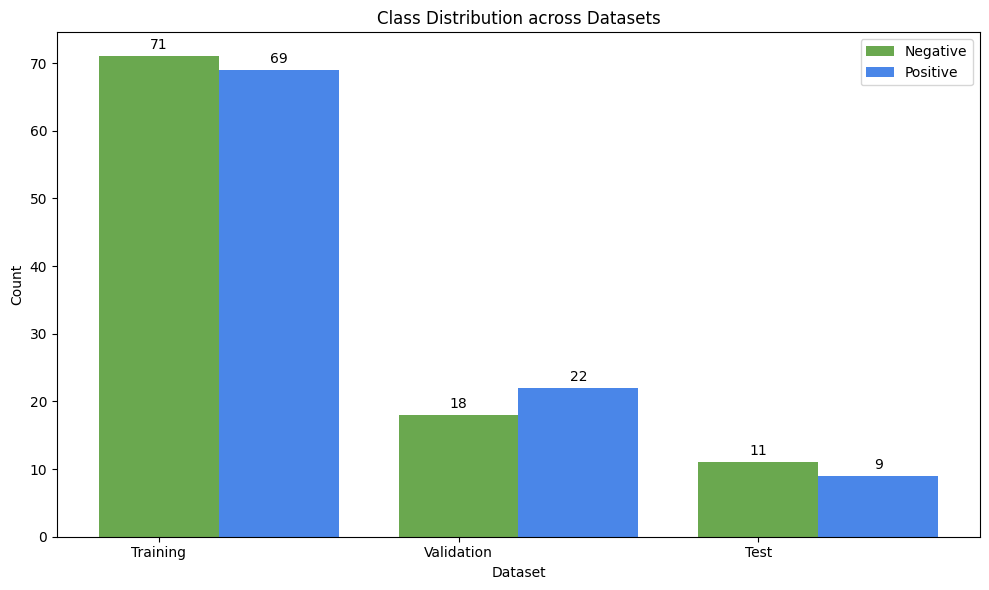

In [ ]:
plot_class_distribution(train, val, test)

In [ ]:
def plot_images_and_masks(images, predictions=None, IoU_list=None):
    num_samples = len(images)
    num_rows = 3 if predictions is not None else 2

    fig, axes = plt.subplots(num_rows, num_samples, figsize=(num_samples * 5, num_rows * 5), dpi=100)
    if num_samples == 1:  # If only one sample, axes are not an array
        axes = np.array([[axes]])
    elif num_rows == 1:  # Ensure axes is 2D if only plotting images or masks
        axes = np.array([axes])

    titles = ['Image', 'Mask', 'Prediction']
    for i in range(num_samples):
        items_to_plot = images[i] + ([predictions[i]] if predictions is not None else [])
        for j, item in enumerate(items_to_plot):
            if isinstance(item, str):  # If the item is a file path
                item = Image.open(item)
            axes[j, i].imshow(item, cmap='gray')
            if j == 2 and IoU_list:  # Specific title for predictions with IoU
                title = f'{titles[j]} | IoU: {round(float(IoU_list[i]), 3)}'
            else:
                title = titles[j]
            axes[j, i].set_title(title, fontsize=15, fontweight='bold')
            axes[j, i].axis('off')

    plt.suptitle('Images, Masks, and Predictions', fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

Positive Samples


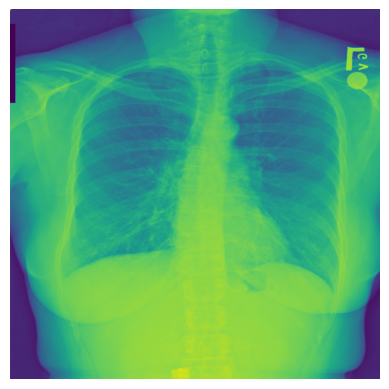

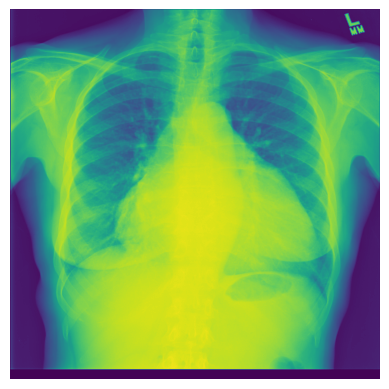

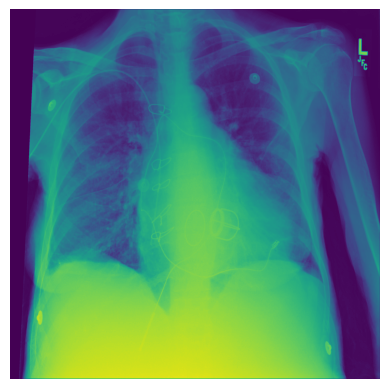

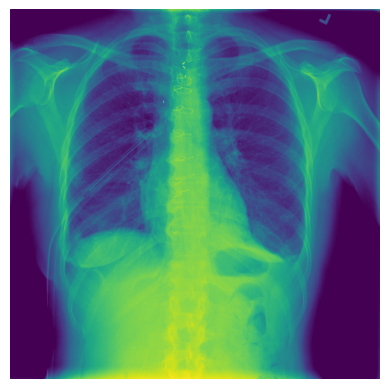

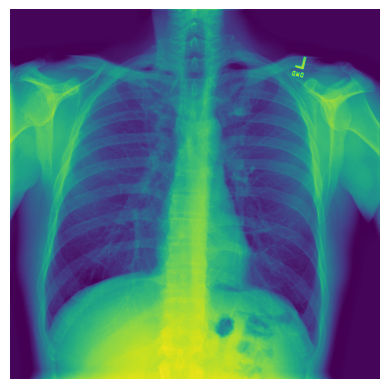

Negative Samples


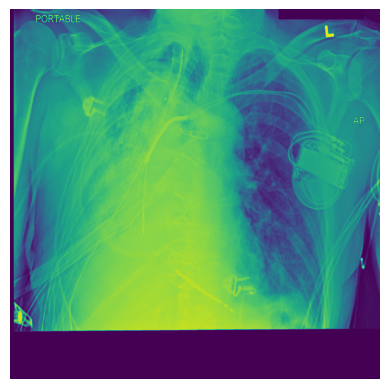

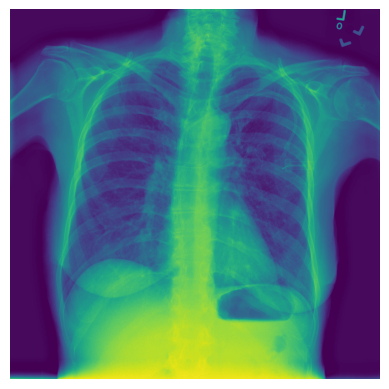

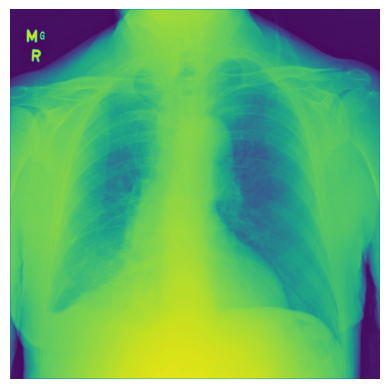

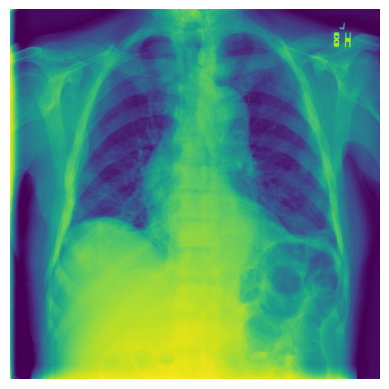

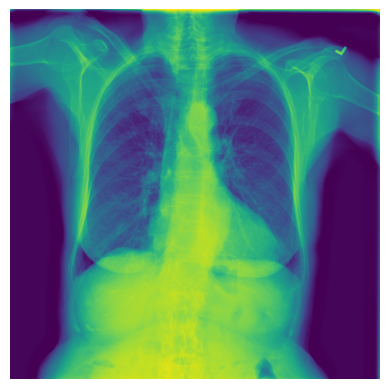

In [ ]:
from PIL import Image

def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

pos = train[train['Finding Labels'] == 1]['Image Path'].values[:5]
neg = train[train['Finding Labels'] == 0]['Image Path'].values[:5]

print("Positive Samples")
for i in range(5):
    show_image(pos[i])

print("Negative Samples")
for i in range(5):
    show_image(neg[i])

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 64
EPOCHS = 20

In [ ]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 64
EPOCHS = 20

# Loads and processes the image file.
def decode_and_resize_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)  # Specify 3 channels for RGB, 1 for grayscale
    img = tf.image.resize(img, IMAGE_SIZE, preserve_aspect_ratio=True)
    # Normalize the image pixels to [0, 1] assuming they are initially [0, 255]
    img = img / 255.0

    return img

def processed_input(img, label):
    return img, label

# Constructs a TensorFlow dataset for model training or evaluation.
def make_dataset(images, labels):
    # Creates a dataset of image and mask pairs, applying decoding and resizing.
    dataset = tf.data.Dataset.from_tensor_slices((
        list(map(decode_and_resize_image, images)),
        labels
    ))

    # Randomly shuffles the dataset to ensure model generalization.
    dataset = dataset.shuffle(BATCH_SIZE * 8)

    # Applies formatting to each dataset item to ensure compatibility with the model input.
    dataset = dataset.map(processed_input, num_parallel_calls=tf.data.AUTOTUNE)

    # Organizes data into batches and prefetches them to improve training efficiency.
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset


In [ ]:
train_dataset = make_dataset(list(train['Image Path'].values),train['Finding Labels'].values)

val_dataset = make_dataset(list(val['Image Path'].values),val['Finding Labels'].values)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

def create_model(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, use sigmoid activation

    return model

# Create the model
input_shape = (256, 256, 3)
model = create_model(input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
)

Epoch 1/20
3/3 [==============================] - 34s 6s/step - loss: 1.4356 - accuracy: 0.4786 - val_loss: 1.0485 - val_accuracy: 0.5500
Epoch 2/20
3/3 [==============================] - 22s 7s/step - loss: 1.0025 - accuracy: 0.4643 - val_loss: 0.9106 - val_accuracy: 0.6000
Epoch 3/20
3/3 [==============================] - 22s 6s/step - loss: 0.9100 - accuracy: 0.5500 - val_loss: 0.8977 - val_accuracy: 0.5500
Epoch 4/20
3/3 [==============================] - 22s 6s/step - loss: 0.8981 - accuracy: 0.5286 - val_loss: 0.9136 - val_accuracy: 0.4500
Epoch 5/20
3/3 [==============================] - 21s 6s/step - loss: 0.9068 - accuracy: 0.5214 - val_loss: 0.8776 - val_accuracy: 0.5500
Epoch 6/20
3/3 [==============================] - 21s 6s/step - loss: 0.8727 - accuracy: 0.4929 - val_loss: 0.8573 - val_accuracy: 0.6750
Epoch 7/20
3/3 [==============================] - 29s 10s/step - loss: 0.8406 - accuracy: 0.6643 - val_loss: 0.8332 - val_accuracy: 0.6250
Epoch 8/20
3/3 [=================

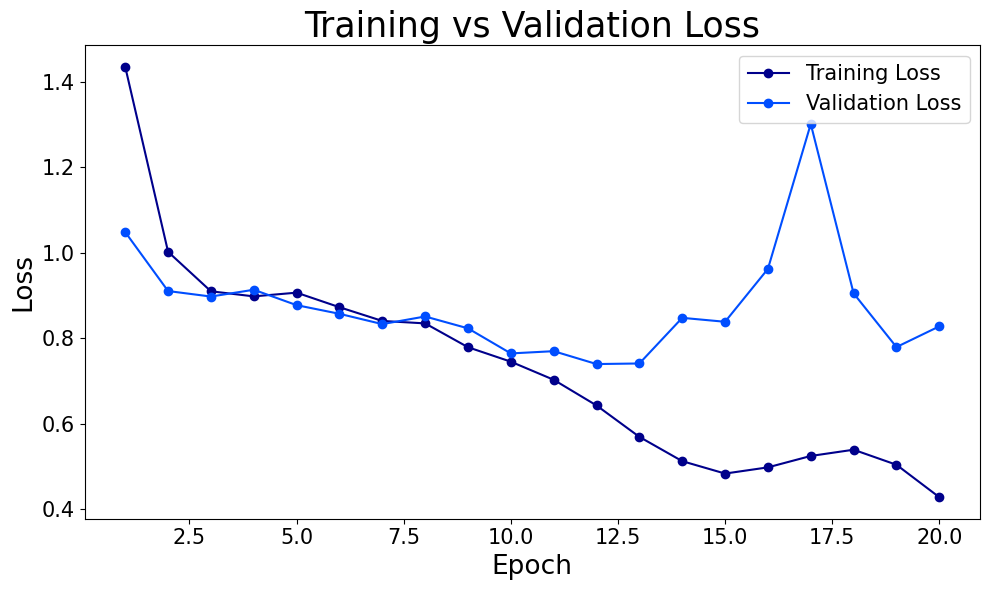

In [ ]:
def plot_loss(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['loss'], 'o-', label='Training Loss', color='#00008B')
    plt.plot(epochs, history.history['val_loss'], 'o-', label='Validation Loss', color="#004EFF")

    # Adding titles and labels
    plt.title('Training vs Validation Loss', fontsize=25)
    plt.xlabel('Epoch', fontsize=19)
    plt.ylabel('Loss', fontsize=19)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='upper right', fontsize=15)

    # Show plot
    plt.tight_layout()
    plt.show()

# Assuming 'history' is defined and contains the training history...
plot_loss(history)

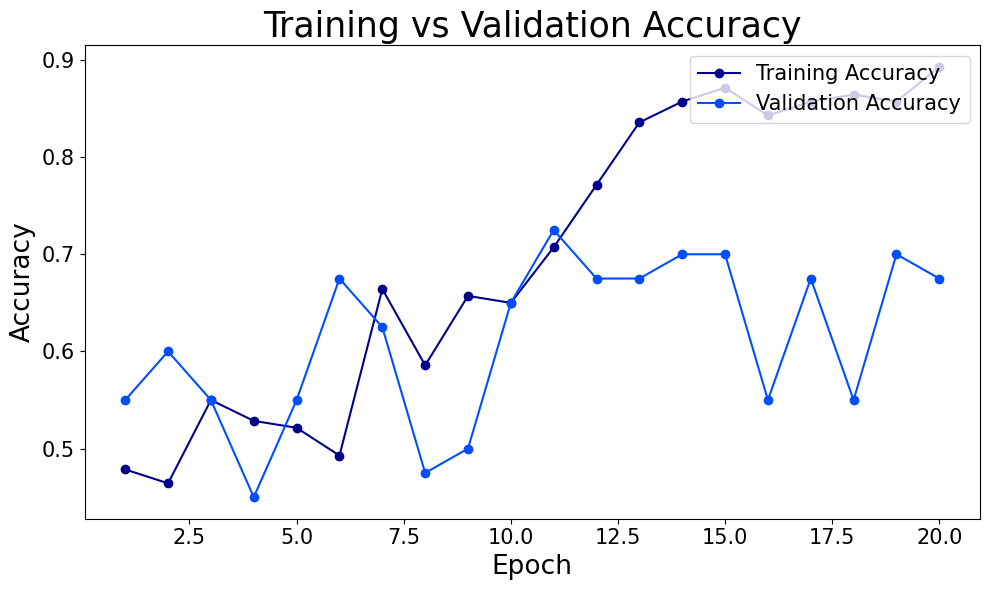

In [ ]:
def plot_accuracy(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Training Accuracy', color='#00008B')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validation Accuracy', color="#004EFF")

    # Adding titles and labels
    plt.title('Training vs Validation Accuracy', fontsize=25)
    plt.xlabel('Epoch', fontsize=19)
    plt.ylabel('Accuracy', fontsize=19)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='upper right', fontsize=15)

    # Show plot
    plt.tight_layout()
    plt.show()

# Assuming 'history' is defined and contains the training history...
plot_accuracy(history)

In [ ]:
image_arrays = np.array([decode_and_resize_image(path) for path in subset['Image Path']])
predictions = model.predict(image_arrays)

7/7 [==============================] - 12s 1s/step


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models

def compute_saliency_map(model, input_image):
    # Convert the input image to a TensorFlow tensor
    input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    input_image_tensor = tf.expand_dims(input_image_tensor, axis=0)  # Add batch dimension

    # Create a GradientTape context to compute gradients
    with tf.GradientTape() as tape:
        tape.watch(input_image_tensor)
        preds = model(input_image_tensor)

    # Get the gradient of the output with respect to the input image
    grads = tape.gradient(preds, input_image_tensor)

    # Compute the saliency map
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    return saliency_map.numpy()

In [ ]:
def generate_heatmap(saliency_map):
    # Normalize the saliency map to values between 0 and 1
    saliency_map_normalized = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    return saliency_map_normalized

In [ ]:
import matplotlib.pyplot as plt

def visualize_heatmap(input_image, heatmap):
    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('Original Image')

    # Plot the heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='pink')
    plt.axis('off')
    plt.title('Saliency Map')

    plt.show()

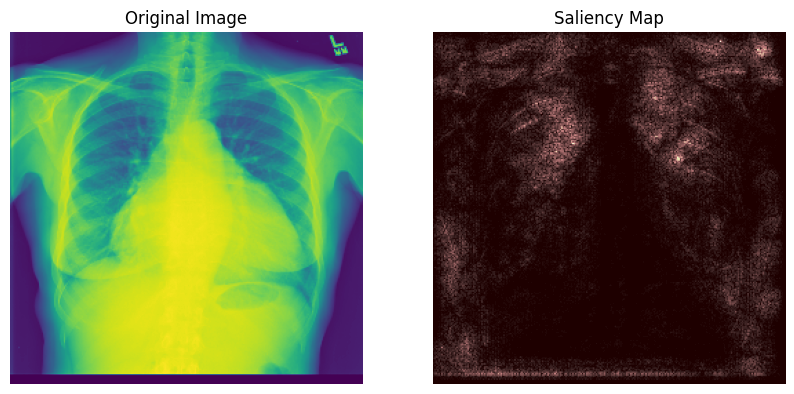

In [ ]:
# Assuming you have loaded your pre-trained model and input image

# Compute the saliency map

img = decode_and_resize_image('images/00000211_006.png')
saliency_map = compute_saliency_map(model, img)

# Generate the heatmap
heatmap = generate_heatmap(saliency_map)

# Visualize the heatmap
visualize_heatmap(img, heatmap)

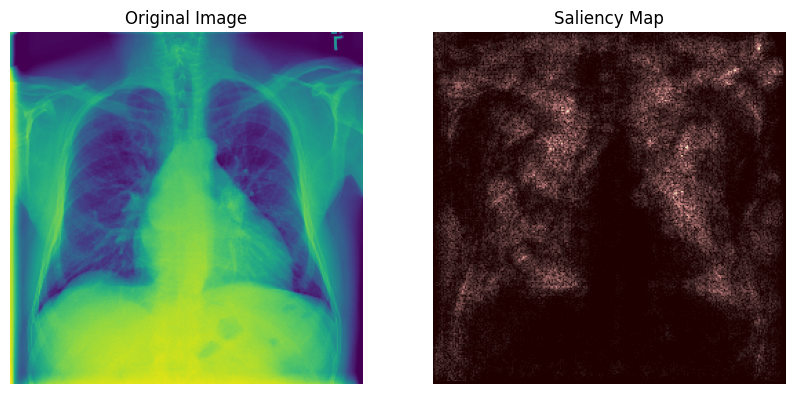

In [ ]:
# Assuming you have loaded your pre-trained model and input image

# Compute the saliency map

img = decode_and_resize_image('images/00000001_000.png')
saliency_map = compute_saliency_map(model, img)

# Generate the heatmap
heatmap = generate_heatmap(saliency_map)

# Visualize the heatmap
visualize_heatmap(img, heatmap)

AUROC Score: 0.9376


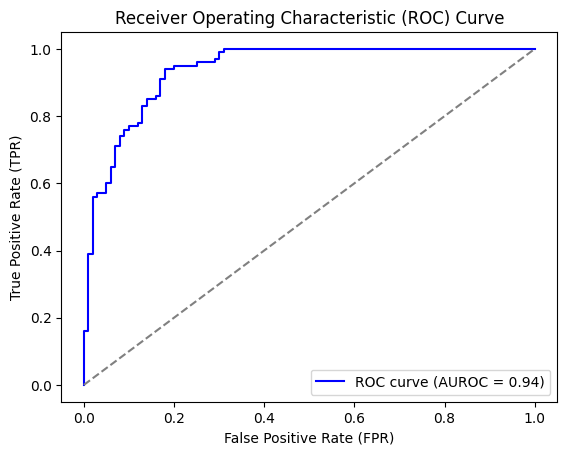

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(subset['Finding Labels'].values, predictions)
# Calculate AUROC
auroc = roc_auc_score(subset['Finding Labels'].values, predictions)
# Print AUROC score
print("AUROC Score:", auroc)
# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()